# NEON Paper Plots (Time-Series) 
## Figure 4: Full time-Series for 2 selected sites
##### Author : Negin Sobhani negins@ucar.edu [@negin513](https://github.com/negin513)

##### Last revised: 2022-09-29
_______

## Creating Climatology Plots for NEON sites

This notebooks is relatively similar to fig3, but instead of climatology it shows time-series for the whole time-period of interest.

This notebook:

1. Creates normal time-series for GPP and NEE comparing model and observation
2. Creates time-series with standard deviation as shaded region for GPP and NEE.

## Imports

In [1]:
import os
import sys
import time
import datetime

import numpy as np
import pandas as pd
import xarray as xr

from glob import glob
from os.path import join, expanduser

import matplotlib
import matplotlib.pyplot as plt

from scipy import stats
import tqdm
from neon_utils import download_eval_files
import matplotlib.colors as colors

## Dask Cluster
The following will spin up a dask cluster,  only works on NCAR machines. 
16 workers worked best for NEON.

In [2]:
from distributed import Client
from ncar_jobqueue import NCARCluster

cluster = NCARCluster()
cluster.scale(16)
client = Client(cluster)
client

/glade/u/apps/opt/conda/envs/npl-2022b/lib/python3.8/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33367 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/33367/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/33367/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.46:43841,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/33367/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
## Useful Functions and Objects

In [4]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
    
def flatten(l):
    return [item for sublist in l for item in sublist]    


In [5]:

class PlotVariable ():
  def __init__(self, short_name, long_name, unit):
    self.short_name = short_name
    self.long_name = long_name
    self.unit = unit
    self.obs_var = short_name
    self.sim_var = 'sim_'+short_name

Plotting functions:

In [6]:
def simple_tseries_new ( df_daily, plot_var, ax,neon_site, plot_dir, color1, color2,  save_switch=False):
    #df_daily.plot ( x= 'time', y = plot_var , marker = 'o' ,ax =ax , color = '#8ECA94',label="NEON")
    #darkgreen
    #df_daily.plot ( x= 'time', y = plot_var , marker = 'o' ,ax =ax , color = 'darkgreen',label="NEON", alpha=0.9)
    #darkblue
    df_daily.plot ( x= 'time', y = 'sim_'+plot_var , marker = 'o', linestyle ='dashed' ,ax =ax , color = color2,label="CTSM", alpha=0.9)

    df_daily.plot ( x= 'time', y = plot_var , marker = 'o' ,ax =ax , color = color1,label="NEON", alpha=0.9)

    #lightblue
    #df_daily.plot ( x= 'time', y = 'sim_'+plot_var ,marker = 's', linestyle ='dashed' ,ax =ax , color = '#5BC2D3',label="CLM", alpha=0.9)
    #orange
    #df_daily.plot ( x= 'time', y = 'sim_'+plot_var , marker = 's', linestyle ='dashed' ,ax =ax , color = '#ffb866',label="CLM", alpha=0.9)

    #ax.set_xlabel('Time', fontsize=17)
    ax.set_ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=17)
    #ax.set_title("2018-2020"+" "+neon_site, fontweight='bold',fontsize=17)

    if save_switch:
        plot_name = neon_site+'_'+year+'_'+plot_var+'_'+'tseries.png'
        plot_dir = os.path.join(plot_dir, plot_var)
        if not os.path.isdir(plot_dir):
            os.mkdir(plot_dir)
        plt.savefig (os.path.join(plot_dir,plot_name), dpi=300,bbox_inches='tight')
    else:
        plt.show()
        
        
def shaded_tseries_new ( df_daily, df_daily_std, plot_var,sim_var, plot_dir,ax, color1, color2,  save_switch=True):
    ax.plot ( df_daily.time, df_daily[sim_var], marker = 'o' , color = color2,label="CLM")

    ax.plot ( df_daily.time, df_daily[plot_var], marker = 'o' , color = color1,label="NEON")
    
    ax.fill_between(df_daily.time, df_daily[plot_var]-df_daily_std[plot_var], df_daily[plot_var]+df_daily_std[plot_var] ,alpha=0.15, color = color1)
    ax.fill_between(df_daily.time, df_daily[sim_var]-df_daily_std[sim_var], df_daily[sim_var]+df_daily_std[sim_var] ,alpha=0.15, color = color2)

    ax.set_xlabel('Time', fontsize=17)
    ax.set_ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=17)
    #ax.set_title(year+" "+neon_site, fontweight='bold',fontsize=17)


    if save_switch:
        plot_name = neon_site+'_'+year+'_'+plot_var+'_'+'tseries_std.png'
        plot_dir = os.path.join(plot_dir, plot_var)
        if not os.path.isdir(plot_dir):
            os.mkdir(plot_dir)
        plt.savefig (os.path.join(plot_dir,plot_name), dpi=300,bbox_inches='tight')
    else:
        plt.show()    
        


## Variables to create plots

Create a list of variables instances for the plots. Here we are only plotting GPP and NEE.

In [41]:
all_vars= [] 

plot_var = 'GPP'
sim_var = 'sim_'+plot_var
plot_var_desc = "Gross Primary Production"
plot_var_unit= "gCm⁻²day⁻¹"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
this_var.min_plot= -3
this_var.max_plot = 18
all_vars.append(this_var)


plot_var = 'NEE'
sim_var = 'sim_'+plot_var
plot_var_desc = "Net Ecosystem Exchange"
plot_var_unit= "gCm⁻²day⁻¹"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
this_var.min_plot= -10.5
this_var.max_plot = 5.5
all_vars.append(this_var)

---------------------------
## 1- Read Simulation files:

In [8]:
neon_sites = [ 
    "KONZ",
    "STEI"
    ]

In [9]:
# -- preprocess function for xarray to read only selected variables

In [10]:
def preprocess (ds):
    variables = ['FCEV', 'FCTR', 'FGEV','FSH','GPP','FSA','FIRA','AR','HR','ELAI']

    ds_new= ds[variables]
    return ds_new

In [11]:
# -- read our sites data

In [33]:
panel_labels = ["(a)", "(b)", "(c)", "(d)", "(e)"]
list_of_df = []
list_of_std =[]

for neon_site in neon_sites:
    try: 
        start_site = time.time()

        print ('---------------------------')
        print ("Making plots for "+neon_site)
        years = ["2018","2019","2020","2021"]
        print ("reading files...")
        sim_all_files =[]
        for year in years:
            sim_path = "/glade/scratch/wwieder/NEON_testV2/archive/"+neon_site+".transient/lnd/hist/"
            #sim_path = "/glade/scratch/negins/neon_v2/tools/site_and_regional/archive/"+neon_site+".transient/lnd/hist/"
            sim_files = sorted(glob(join(sim_path,neon_site+".transient.clm2.h1."+year+"*.nc")))
            sim_all_files.append(sim_files)
            print("All simulation files for "+ year+" : [", len(sim_files), "files]")
            #print(*sim_files,sep='\n')

        sim_all_files = flatten (sim_all_files)

        print("All Simulation files for all years: [", len(sim_all_files), "files]")

        print ("Start reading v2 simulation data...")
        start = time.time()

        ds_ctsm = xr.open_mfdataset(sim_all_files, decode_times=True, combine='by_coords',parallel=True,preprocess=preprocess)

        end = time.time()
        print("Reading all simulation files took:", end-start, "s.")

        all_eval_files = []
        for year in years:
            #eval_dir = "/glade/work/negins/neon_scripts/notebooks/evaluation_files_2/"+neon_site
            eval_dir_2 = "/glade/work/wwieder/neon/eval_files/"+neon_site
            eval_files_2 = sorted(glob(join(eval_dir_2,neon_site+"_eval_"+year+"*.nc")))
            #print (join(eval_dir_2,neon_site+"_eval_"+year+"*.nc"))
            #print("All Observation files:")
            print("All evaluation files for "+year+" : [", len(eval_files_2), "files]")
            all_eval_files.append(eval_files_2)
        all_eval_files = flatten (all_eval_files)

        start = time.time()

        ds_eval = xr.open_mfdataset(all_eval_files, decode_times=True, combine='by_coords')

        end = time.time()
        print("Reading all observation files took:", end-start, "s.")

        print ("processing data...")
        #Convert CTSM data to a Pandas Dataframe for easier handling:
        ctsm_vars = ['FCEV', 'FCTR', 'FGEV','FSH','GPP','FSA','FIRA','AR','HR','ELAI']

        df_ctsm = pd.DataFrame({'time':ds_ctsm.time})

        for var in tqdm.tqdm(ctsm_vars):
            field = np.ravel ( ds_ctsm[var])     
            df_ctsm[var]=field


        #Convert NEON data to a Pandas Dataframe for easier handling:
        eval_vars = ['NEE','FSH','EFLX_LH_TOT','GPP','Rnet']

        df_eval = pd.DataFrame({'time':ds_eval.time})

        for var in tqdm.tqdm(eval_vars):
            field = np.ravel (ds_eval[var])
            df_eval[var]=field

        #-- make df_all that includes both obs and sim
        df_all = df_eval
        #-- add simulation data to df_all and adjust for offset time dimension:
        for var in ctsm_vars:
            sim_var_name = "sim_"+var
            #-- shift simulation data by one
            df_all[sim_var_name]=df_ctsm[var].shift(-1).values

        clm_var = 'sim_EFLX_LH_TOT'

        #EFLX_LH_TOT = FCEV + FCTR +FGEV
        df_all [clm_var] = df_all['sim_FCEV']+ df_all['sim_FCTR']+ df_all['sim_FGEV']

        # In[17]:
        clm_var = 'sim_Rnet'
        # Rnet = FSA-FIRA
        df_all [clm_var] = df_all ['sim_FSA']-df_all['sim_FIRA']

        clm_var = 'sim_NEE'
        # Rnet = GPP- (AR+HR)
        # It seems like the sign are opposite so we calculated negative NEE
        df_all [clm_var] = -(df_all ['sim_GPP']-(df_all['sim_AR']+df_all['sim_HR']))

        # convert NEE units from  umolm-2s-1 to gc/m2/s
        #df_all ['NEE']= df_all ['NEE']*(12.01/1000000)
        #df_all ['GPP']= df_all ['GPP']*(12.01/1000000)
        df_all ['NEE']= df_all ['NEE']*(12.01/1000000)
        df_all ['GPP']= df_all ['GPP']*(12.01/1000000)

        #df_all ['NEE']= df_all['NEE']*60*60*24
        df_all ['NEE']= df_all['NEE']*60*60*24
        df_all ['sim_NEE']= df_all['sim_NEE']*60*60*24

        #df_all ['GPP']= df_all['GPP']*60*60*24
        df_all ['GPP']= df_all['GPP']*60*60*24

        df_all ['sim_GPP']= df_all['sim_GPP']*60*60*24

        #-- extract year, month, day, hour information from time
        df_all['year'] = df_all['time'].dt.year
        df_all['month'] = df_all['time'].dt.month
        df_all['day'] = df_all['time'].dt.day
        df_all['hour'] = df_all['time'].dt.hour

        # Try skipping days with NA values to avoid odd resutls on the back side of observational gaps
        df_daily = df_all.groupby(['year','month','day']).mean().reset_index()
        #df_daily['time']=pd.to_datetime(df_daily[["year", "month", "day"]])
        df_count = df_all.groupby(['year','month','day']).count().reset_index()
        df_daily = df_daily.where(df_count == 48)
        df_daily['time']=pd.to_datetime(df_all.groupby(['year','month','day']).mean().reset_index()[["year", "month", "day"]])
        df_daily['year']=(df_all.groupby(['year','month','day']).mean().reset_index()[["year"]])
        df_daily['month']=(df_all.groupby(['year','month','day']).mean().reset_index()[["month"]])
        df_daily['day']=(df_all.groupby(['year','month','day']).mean().reset_index()[["day"]])


        df_climo = df_all.groupby(['month','day']).mean().reset_index()
        df_climo['year']='2020'
        df_climo['time']=pd.to_datetime(df_daily[["year","month", "day"]])

        df_daily_std = df_all.groupby(['year','month','day']).std().reset_index()
        df_daily_std['time'] = pd.to_datetime(df_daily_std[["year", "month", "day"]])

        df_monthly = df_all.groupby(['year','month']).mean().reset_index()
        df_monthly["day"]=15
        df_monthly['time']=pd.to_datetime(df_monthly[["year", "month","day"]])

        # Calculate annual average diel cycle and bias
        diel_df_mean = df_all.groupby('hour').mean().reset_index()
        diel_df_std = df_all.groupby('hour').std().reset_index()

        #diel_df_mean['EFLX_LH_TOT_bias'] = diel_df_mean['sim_EFLX_LH_TOT']- diel_df_mean['EFLX_LH_TOT']

        diel_df_mean.head()

        tzone_shift = ds_eval.TimeDiffUtcLt


        #convert to local time
        df_all['local_time']= df_all['time'] + datetime.timedelta(hours=int(tzone_shift))

        df_all['local_hour'] = df_all['local_time'].dt.hour

        # Calculate annual average diel cycle and bias
        diel_df_mean = df_all.groupby('local_hour').mean().reset_index()
        diel_df_std = df_all.groupby('local_hour').std().reset_index()

        #diel_df_mean['EFLX_LH_TOT_bias'] = diel_df_mean['sim_EFLX_LH_TOT']- diel_df_mean['EFLX_LH_TOT']
        diel_df_mean.head()

        df_daily['site']=neon_site
        df_daily_std['site']=neon_site

        list_of_df.append(df_daily)
        list_of_std.append(df_daily_std)
        
    except:
        pass

---------------------------
Making plots for KONZ
reading files...
All simulation files for 2018 : [ 365 files]
All simulation files for 2019 : [ 365 files]
All simulation files for 2020 : [ 366 files]
All simulation files for 2021 : [ 365 files]
All Simulation files for all years: [ 1461 files]
Start reading v2 simulation data...
Reading all simulation files took: 11.626116514205933 s.
All evaluation files for 2018 : [ 12 files]
All evaluation files for 2019 : [ 12 files]
All evaluation files for 2020 : [ 12 files]
All evaluation files for 2021 : [ 12 files]
Reading all observation files took: 0.9514143466949463 s.
processing data...


100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


---------------------------
Making plots for STEI
reading files...
All simulation files for 2018 : [ 365 files]
All simulation files for 2019 : [ 365 files]
All simulation files for 2020 : [ 366 files]
All simulation files for 2021 : [ 365 files]
All Simulation files for all years: [ 1461 files]
Start reading v2 simulation data...
Reading all simulation files took: 10.141510963439941 s.
All evaluation files for 2018 : [ 12 files]
All evaluation files for 2019 : [ 12 files]
All evaluation files for 2020 : [ 12 files]
All evaluation files for 2021 : [ 12 files]
Reading all observation files took: 0.9371800422668457 s.
processing data...


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


concatenate datasets to create one dataset for both sites:

In [35]:
df_all_sites =  pd.concat(list_of_df)
std_all_sites = pd.concat (list_of_std)

## Time-Series GPP and NEE for both sites

Plotting Gross Primary Production


2it [00:04,  2.01s/it]


Saving /glade/work/wwieder/neon_vis_plots/paper_plots_final/Fig4/GPP_2sites_daily_average_tseries_Fig4.png
Saving /glade/work/wwieder/neon_vis_plots/paper_plots_final/Fig4/GPP_2sites_daily_average_tseries_Fig4.pdf


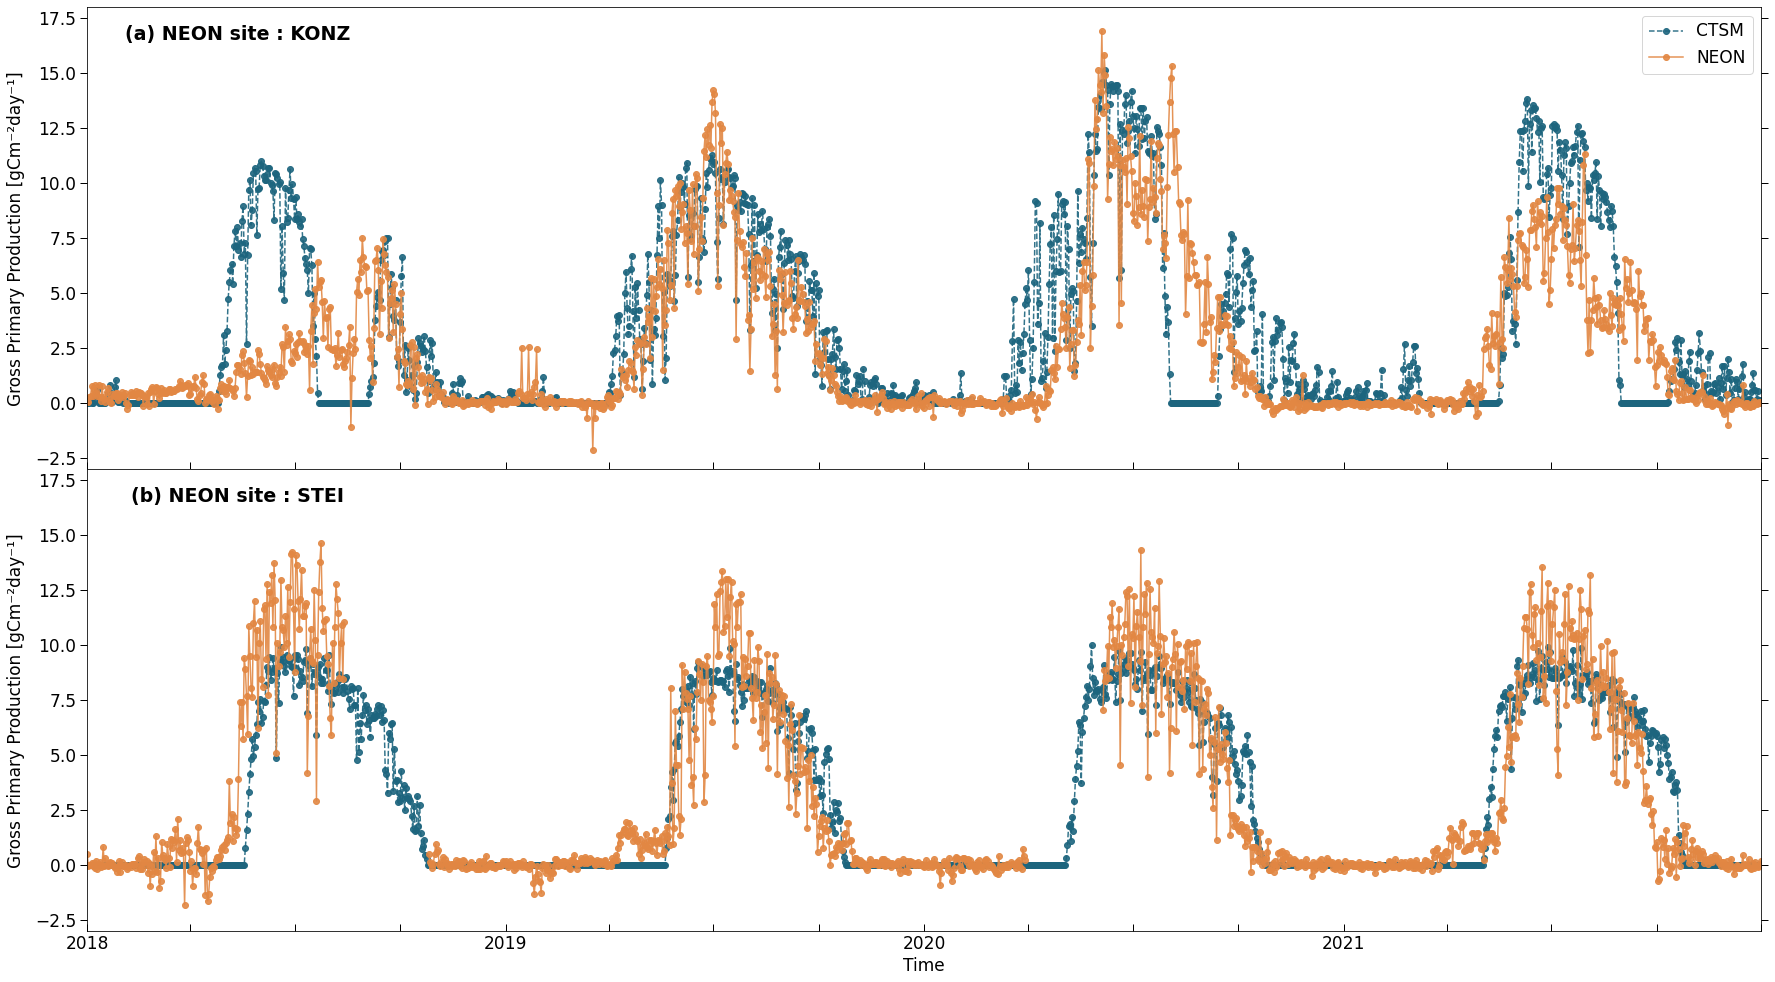

Plotting Net Ecosystem Exchange


2it [00:03,  1.98s/it]


Saving /glade/work/wwieder/neon_vis_plots/paper_plots_final/Fig4/NEE_2sites_daily_average_tseries_Fig4.png
Saving /glade/work/wwieder/neon_vis_plots/paper_plots_final/Fig4/NEE_2sites_daily_average_tseries_Fig4.pdf


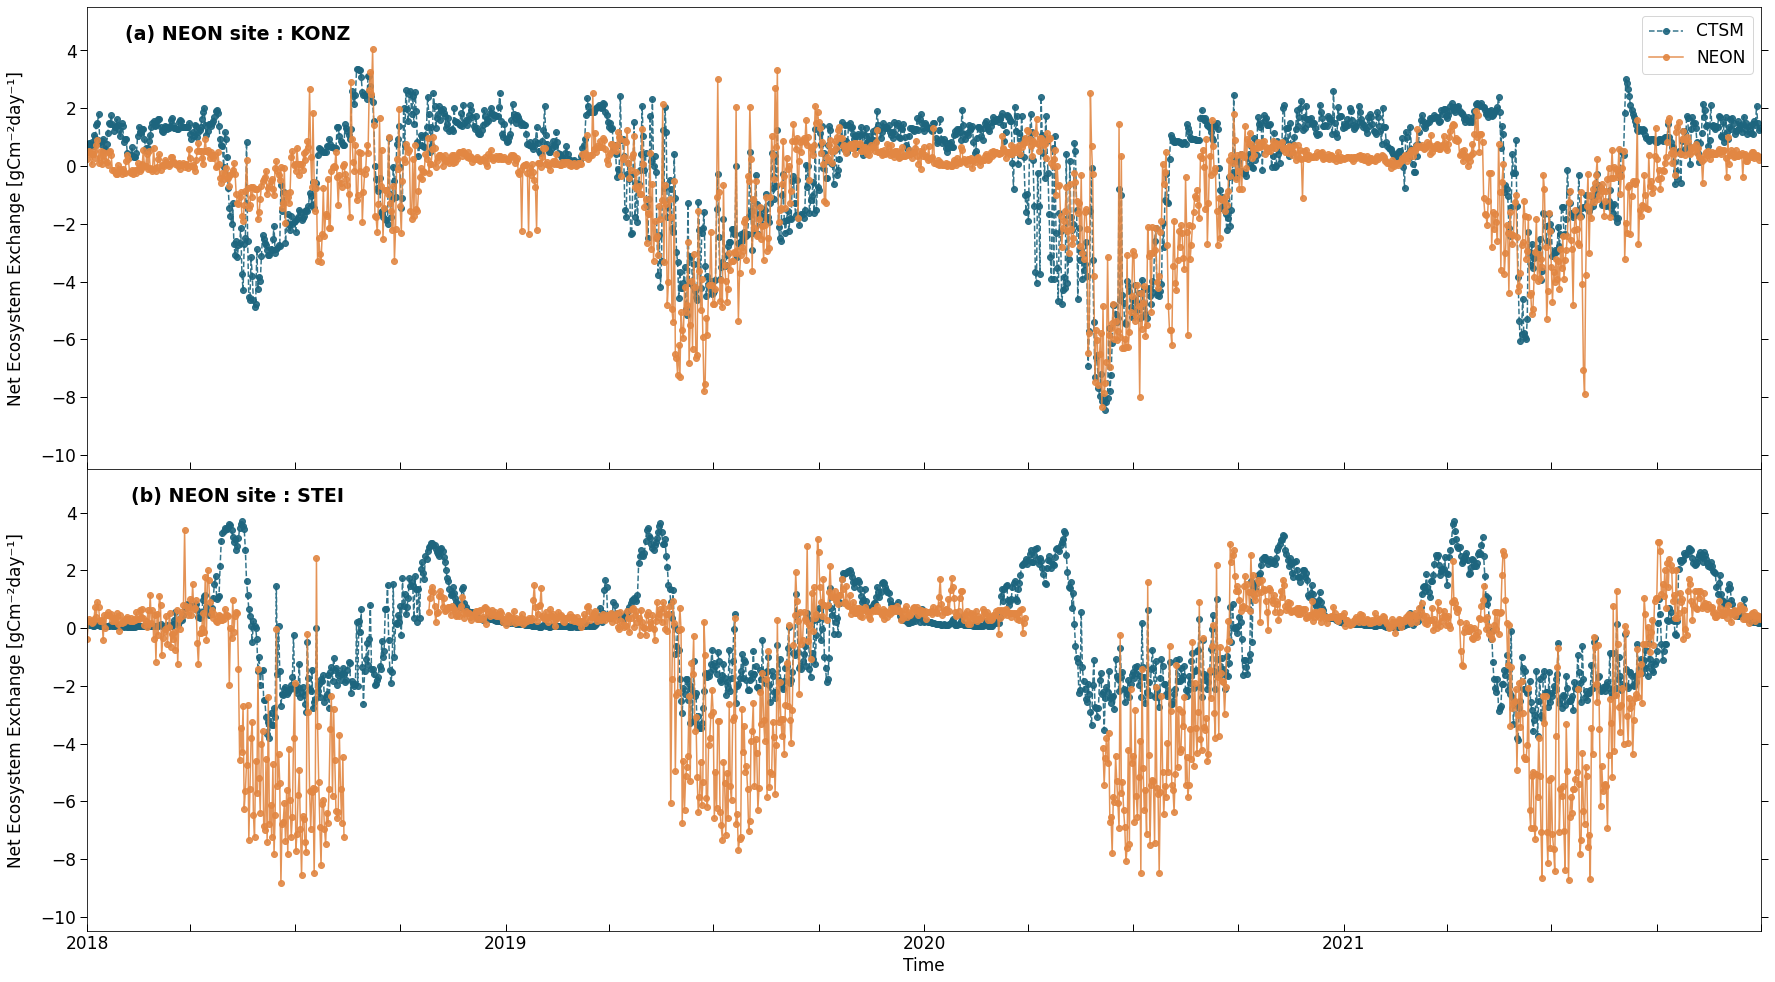

In [42]:
plot_dir = "/glade/work/wwieder/neon_vis_plots/paper_plots_final/Fig4/"
#plot_dir = "/glade/work/negins/neon_vis_plots/paper_plots"
save_switch = "True"
if not os.path.isdir(plot_dir):
    os.mkdir(plot_dir)
    
for var in all_vars:
    
    fig = plt.figure(num=None, figsize=(30, 17),  facecolor='w', edgecolor='k')
    axes = fig.subplots(nrows=2, ncols=1)
    axe = axes.ravel()
    index = 0
    
    #color1 = '#f7aa15'
    #color1 = '#f7aa15'
    color2 = '#1d657e'
    color1 = '#e28743'

    print ("Plotting "+ var.long_name)
    plot_var = var.obs_var
    sim_var = var.sim_var
    plot_var_desc = var.long_name
    plot_var_unit = var.unit


    for idx, neon_site in tqdm.tqdm(enumerate(neon_sites)):
        df_this = df_all_sites[df_all_sites['site']==neon_site]
    
        ax = axe[index]
        simple_tseries_new ( df_this, plot_var, ax, neon_site, plot_dir, color1, color2, save_switch)

        #ax.set_xticks([])
        ax.text(.09,0.93,panel_labels[index]+' NEON site : '+neon_site,
            horizontalalignment='center',
            transform=ax.transAxes, fontweight='bold',fontsize=19)
        index = index+1

        ax.get_yaxis().set_label_coords(-0.037,0.5)
        ax.tick_params(axis='both', which='both', labelsize=17,width=1,length=6)
        ax.tick_params(axis='x',which = 'both', direction="in")
        ax.set_ylim(var.min_plot, var.max_plot)


        
        if index == 1:
            ax.set_xticklabels([])

            ax.legend(fontsize = 17)

        else:
            ax.get_legend().remove()
            ax.set_xlabel('Time', fontsize=17)

        ax.tick_params(axis='x',direction="in", length = 7)
        ax.yaxis.set_ticks_position('both')
        #ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis='y',direction="out", length = 7)
        ax.tick_params(axis='both', which='both', labelsize=17,width=1,length=7)

    #plt.xticks(rotation=45)
        
    fig.subplots_adjust(wspace=0, hspace=0)

    #fig.tight_layout()
    #plt.subplots_adjust(top=0.99)

    plot_name = plot_var+'_'+'2sites_'+'daily_average_tseries_Fig4.png'

    print ('Saving '+ os.path.join(plot_dir,plot_name))
    
    plt.savefig (os.path.join(plot_dir,plot_name), dpi=600,bbox_inches='tight')
    
    
    plot_name = plot_var+'_'+'2sites_'+'daily_average_tseries_Fig4.pdf'

    print ('Saving '+ os.path.join(plot_dir,plot_name))
    
    plt.savefig (os.path.join(plot_dir,plot_name), dpi=600,bbox_inches='tight', format='pdf')
    
    #plt.close(fig)
    plt.show()

In [43]:
## Time-Series with Standard Deviation as shaded bands

Plotting Gross Primary Production


2it [00:03,  1.94s/it]


Saving /glade/work/wwieder/neon_vis_plots/paper_plots_final/Fig4/GPP_2sites_daily_average_std_tseries.png


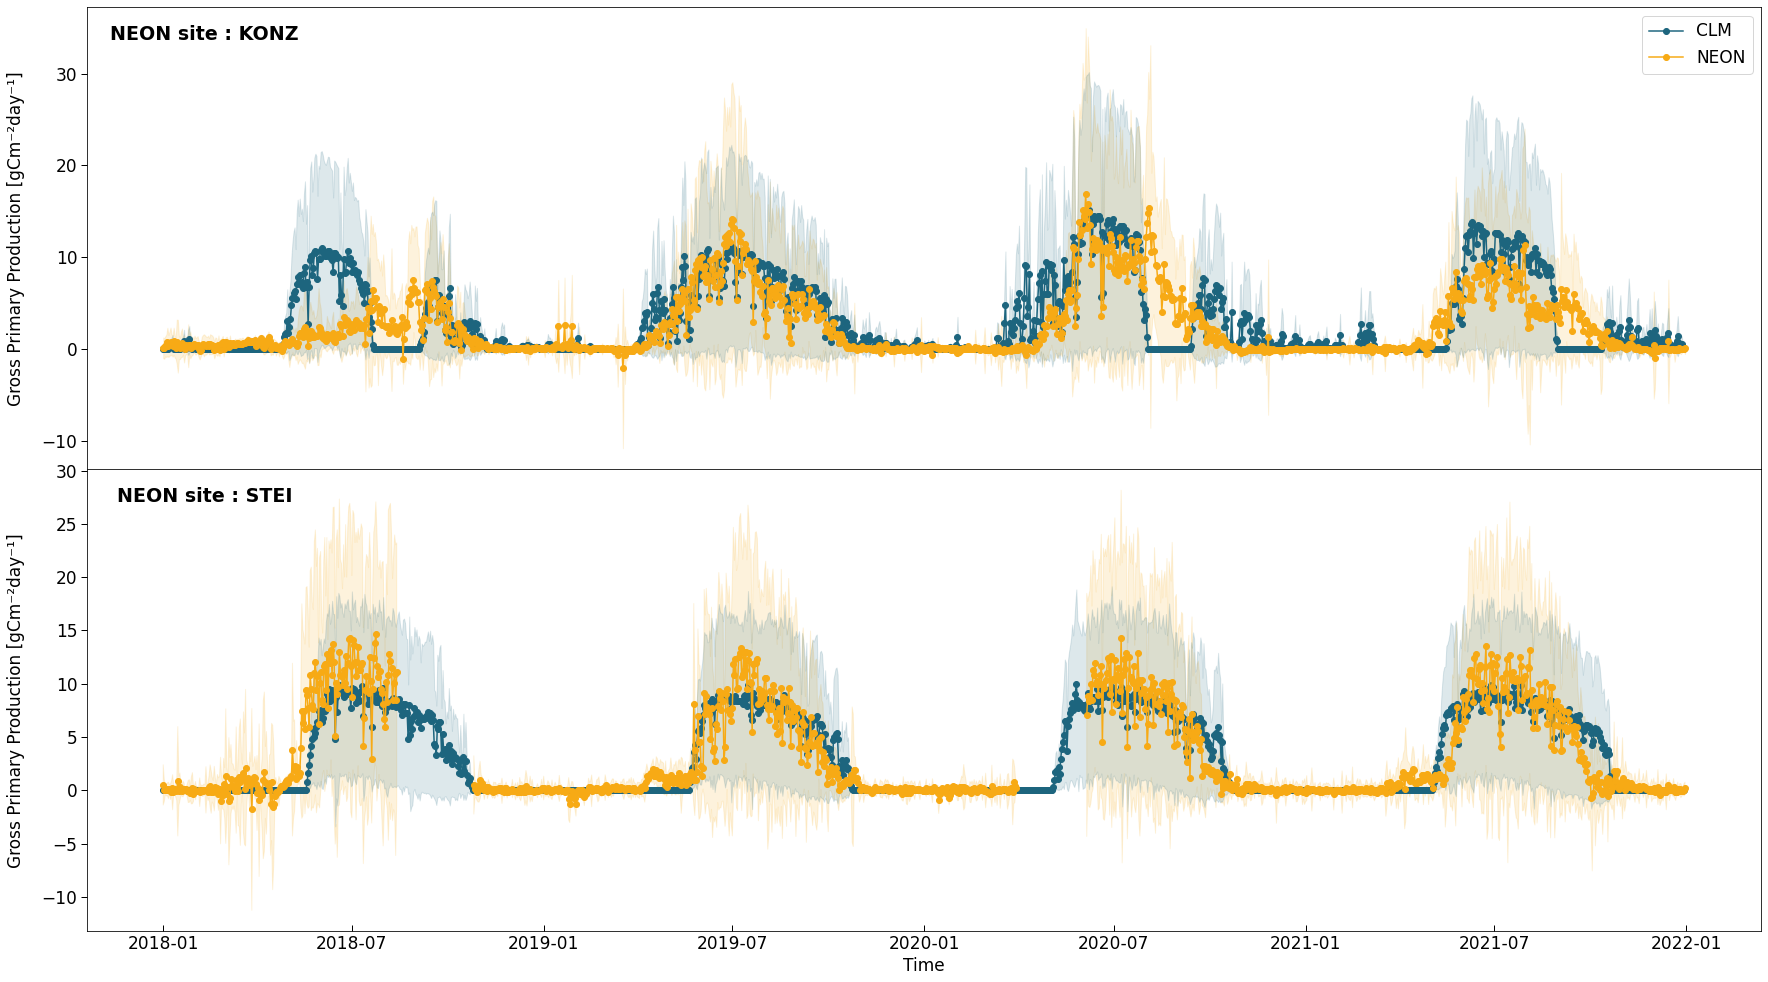

Plotting Net Ecosystem Exchange


2it [00:04,  2.00s/it]


Saving /glade/work/wwieder/neon_vis_plots/paper_plots_final/Fig4/NEE_2sites_daily_average_std_tseries.png


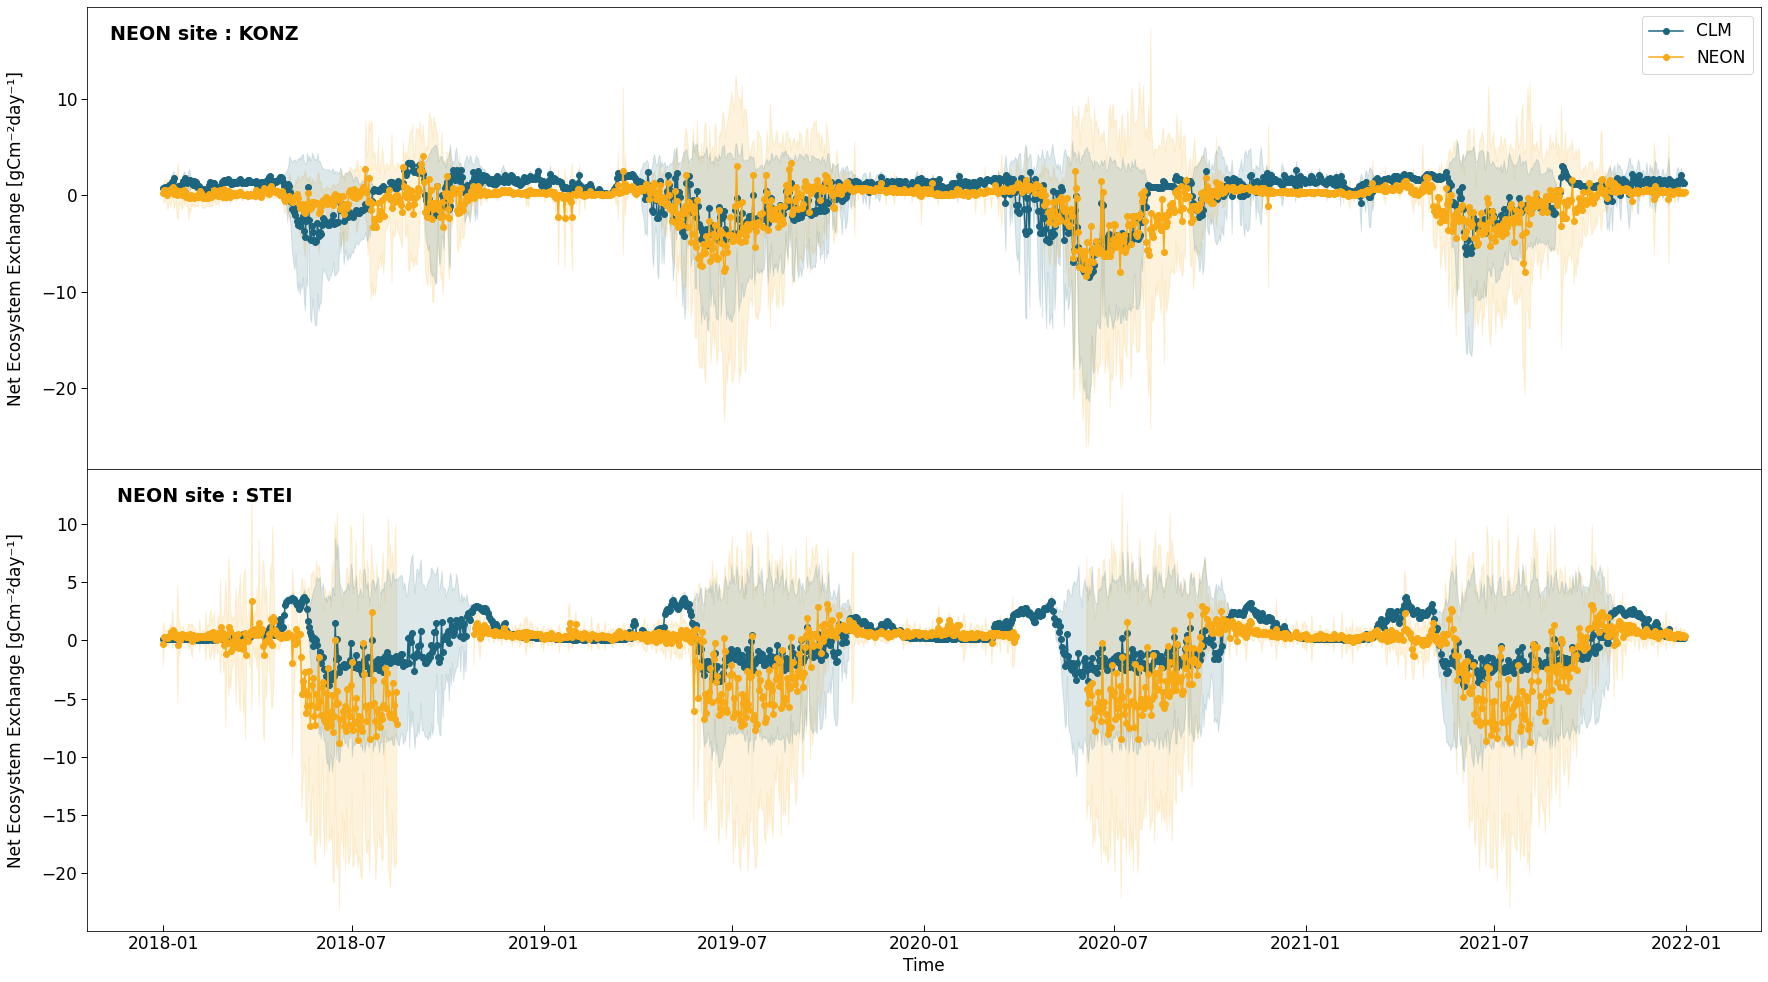

In [44]:
for var in all_vars:
    
    fig = plt.figure(num=None, figsize=(30, 17),  facecolor='w', edgecolor='k')
    axes = fig.subplots(nrows=2, ncols=1)
    axe = axes.ravel()
    index = 0
    
    color1 = '#f7aa15'
    #color1 = '#f7aa15'
    color2 = '#1d657e'
    
    print ("Plotting "+ var.long_name)
    plot_var = var.obs_var
    sim_var = var.sim_var
    plot_var_desc = var.long_name
    plot_var_unit = var.unit


    for idx, neon_site in tqdm.tqdm(enumerate(neon_sites)):
        df_this = df_all_sites[df_all_sites['site']==neon_site]
        df_this_std = std_all_sites[std_all_sites['site']==neon_site]

    
        ax = axe[index]
        shaded_tseries_new ( df_this, df_this_std, plot_var, sim_var , plot_dir, ax, color1, color2, save_switch)
        index = index+1

        #ax.set_xticks([])
        ax.text(.07,0.93,'NEON site : '+neon_site,
            horizontalalignment='center',
            transform=ax.transAxes, fontweight='bold',fontsize=19)
        ax.get_yaxis().set_label_coords(-0.037,0.5)
        ax.tick_params(axis='both', which='both', labelsize=17,width=1,length=6)
        ax.tick_params(axis='x',which = 'both', direction="in")
        #ax.set_ylim(var.min_plot, var.max_plot)

        if index == 1:
            ax.set_xticks([])
            ax.legend(fontsize = 17)

        else:
            #ax.get_legend().remove()
            ax.set_xlabel('Time', fontsize=17)

    fig.subplots_adjust(wspace=0, hspace=0)

    #fig.tight_layout()
    #plt.subplots_adjust(top=0.99)

    plot_name = plot_var+'_'+'2sites_'+'daily_average_std_tseries.png'

    print ('Saving '+ os.path.join(plot_dir,plot_name))
    
    plt.savefig (os.path.join(plot_dir,plot_name), dpi=300,bbox_inches='tight')
    #plt.close(fig)
    plt.show()